<font size="6" style="color:#ce4257">AMEX : EDA</font>

<font size="5" style="color:#219ebc">Table of contents</font>

- [Introduction](#1)

- [Data Overview](#2)

- [Features correlations](#3)

- [Feature distribution](#4)

- [Missing data](#6)

- [Target distribution and correlations](#7)

In [1]:
%%capture --no-display
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import plotly.graph_objects as go

!pip install dython
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,rgb2hex 
from dython.nominal import associations
from matplotlib.ticker import FormatStrFormatter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    LabelBinarizer,
    MinMaxScaler,
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import xgboost
import torch

In [2]:
def get_colormap(N:int):
    rgb_colors = LinearSegmentedColormap.from_list('my_colormap',
                                    ['#bbd5de','#6495ed','#ff355d'],
                                    N=N)
    hex_colors = [rgb2hex(rgb_colors(i)) for i in range(rgb_colors.N)]
    return rgb_colors,hex_colors

<font size="5" style="color:#219ebc">1. Introduction</font>
<div id="1">
    
- Default risk is the probability that if you lend money, there is a chance that the borrowers won’t be able to give the money back on time. 

- Lenders and investors are exposed to default risk in virtually all forms of credit extensions. 
    
- The objective is to predict the probability that a customer does not pay back their credit card balance in the future based on their monthly customer profile.
    
- There are a total of 190 features in the dataset with approximately 450,000 customers in the training set.

In [3]:
TRAIN_CSV = '../input/amaxcompr/train_inputed.ftr'
TEST_CSV = '../input/amaxcompr/processed_test_df.ftr'


In [4]:
train_df = pd.read_feather(TRAIN_CSV)
train_df

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,3.18816,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
1,3.36096,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
2,3.16224,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
3,3.13632,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
4,3.15360,0.872070,0.005573,0.007679,0.815918,0.001247,0.176392,0.000231,0.005527,NaN,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,3.24864,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,NaN,...,NaN,NaN,0.007919,0.001519,0.005531,NaN,0.001431,0.003010,0.004845,0
458909,3.15360,0.831055,0.033661,0.292480,0.055664,0.006954,0.194702,0.005791,0.233032,NaN,...,NaN,NaN,0.004395,0.006184,0.001479,NaN,0.004795,0.009232,0.006435,0
458910,3.07584,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,NaN,...,NaN,NaN,0.006035,0.002869,0.002150,NaN,0.008034,0.000340,0.002148,0
458911,3.13632,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,NaN,...,NaN,NaN,1.009766,0.004478,0.949707,0.446289,1.009766,0.002502,0.185547,1


<font size="5" style="color:#219ebc">2. Data Overview</font>
<div id="2">
The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. 

Features are anonymized and normalized, and fall into the following general categories:

- D_*: Delinquency variables
- S_*: Spend variables
- P_*: Payment variables
- B_*: Balance variables
- R_*: Risk variables

With the following features being categorical: D_63, D_64, D_66, D_68, B_30, B_38, D_114, D_116, D_117, D_120, D_126.

Although they repressent only 5% of the total training set , 95% of features are numerical.



In [5]:
train_df.select_dtypes(include='category').columns

Index(['D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116',
       'D_117', 'D_120', 'D_126'],
      dtype='object')

In [6]:
def plot_pie(data:pd.Series,title:str,size:int,ax=None) -> None:
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.set_title(title,fontsize=24,color='#555555')
    data.plot(kind='pie',
                      figsize=(size,size),
                      colormap=get_colormap(60)[0],
                      explode=[i*0.12 for i in range(0,len(data))],
                      pctdistance=1.15,
                      labeldistance=None,
                     ax=ax).get_yaxis().set_visible(False)
    ax.legend(fontsize=12)
    labels = data.index
    perc = data.values*100/data.values.sum()
    labels = [f'{label}: {value:0.2f}%' for label,value in zip(labels,perc)]
    ax.legend(labels=labels,fontsize=11)

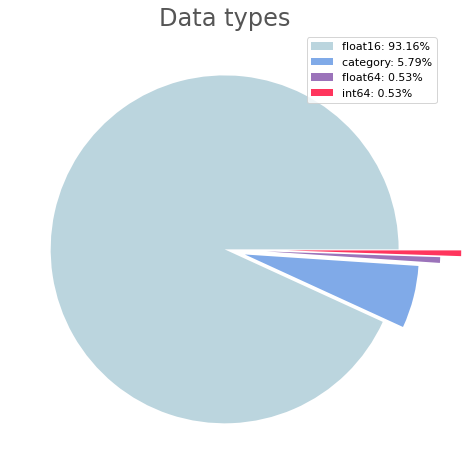

In [7]:
dtypes_counts = train_df.dtypes.astype(str).value_counts()
plot_pie(dtypes_counts,'Data types',8)

<font size="5" style="color:#219ebc">Check duplicates</font>

In [8]:
train_df.duplicated().any()

False

<font size="5" style="color:#219ebc">Check features correlations</font>
<div id="3">
There are several highly correlated Delinquency variables, with 10 out of 190 almost perfectly correlated at 1.0. 

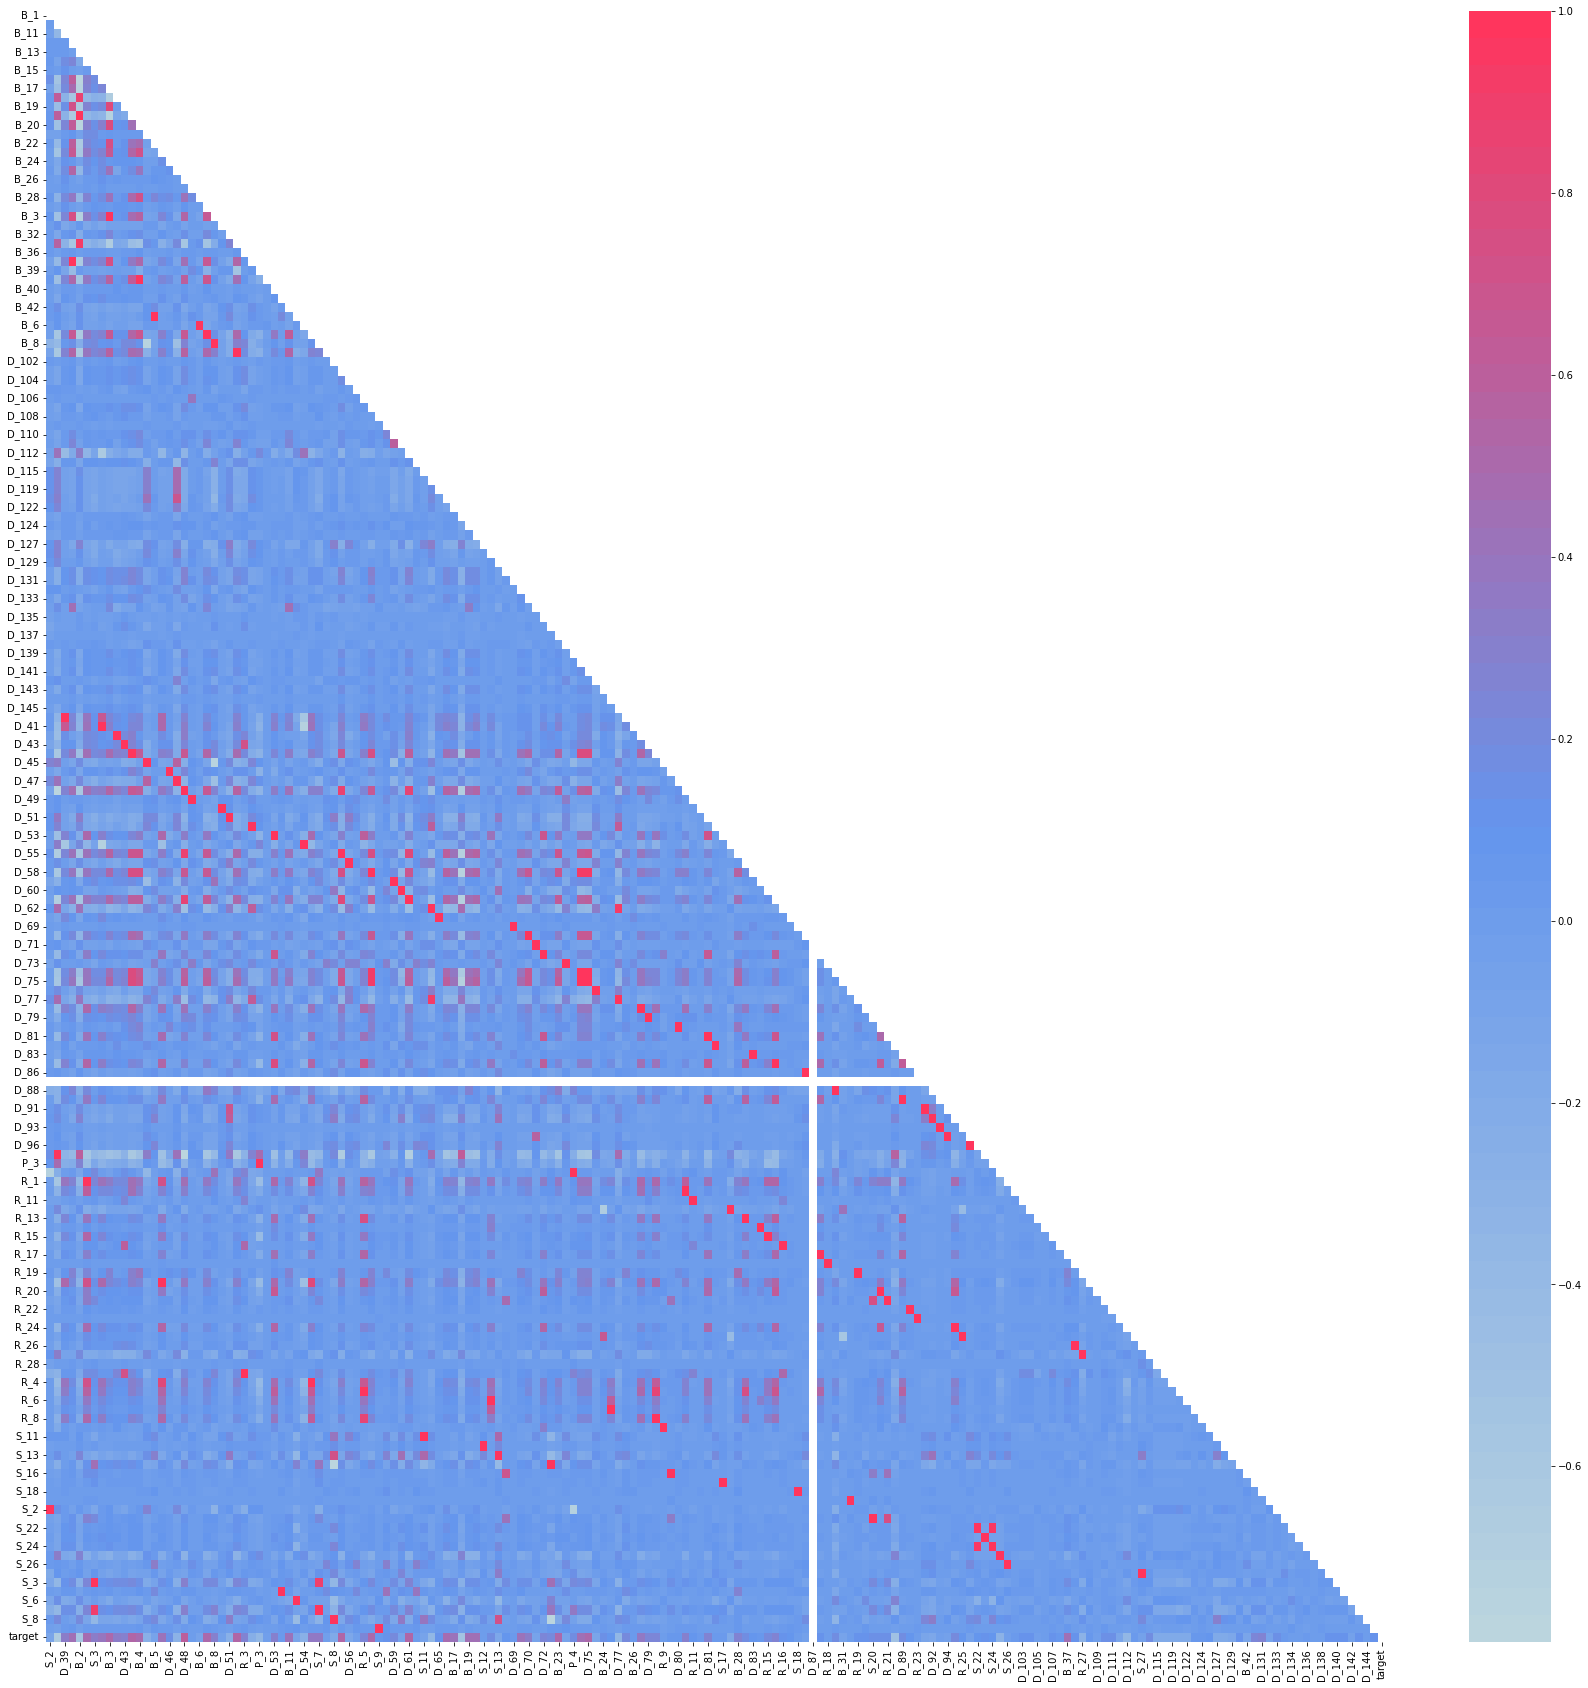

In [9]:
plt.figure(figsize=(30,30))
cols = train_df.columns.to_list()
corr = train_df.corr().sort_index()
diagonal_mask=np.triu(corr)# show only lower diagonal values
sb.heatmap(corr,cmap=get_colormap(60)[0],mask=diagonal_mask,)
plt.show()

In [10]:
def get_numerical_correlated(df:pd.DataFrame,thresh:float=0.99)->list:  
    features_to_drop=[]
    df = df.select_dtypes(include=np.number)
    corr=df.corr()
    for feature in range(len(corr)):
        for other_feature in range(len(corr)):
            
            if feature!=other_feature and \
               df.columns[other_feature] not in features_to_drop and \
               abs(corr.iloc[feature][other_feature]) >= thresh:
                
                print(f"{df.columns[feature]} and {df.columns[other_feature]} are highly correlated ({corr.iloc[feature][other_feature]:.3f})") 
                features_to_drop.append(df.columns[feature])
                break
    return features_to_drop         
    #df.drop(columns=features,inplace=True) 

In [11]:
get_numerical_correlated(train_df,0.90)

B_1 and B_11 are highly correlated (0.996)
B_2 and B_33 are highly correlated (0.919)
S_3 and S_7 are highly correlated (0.908)
B_7 and B_23 are highly correlated (0.995)
B_11 and B_37 are highly correlated (0.988)
B_12 and B_13 are highly correlated (0.906)
D_58 and D_74 are highly correlated (0.924)
B_14 and B_15 are highly correlated (0.901)
D_62 and D_77 are highly correlated (0.934)
D_74 and D_75 are highly correlated (0.989)
S_22 and S_24 are highly correlated (0.965)
D_103 and D_104 are highly correlated (1.000)
D_118 and D_119 are highly correlated (0.996)
D_139 and D_141 are highly correlated (0.998)
D_141 and D_143 are highly correlated (0.998)


['B_1',
 'B_2',
 'S_3',
 'B_7',
 'B_11',
 'B_12',
 'D_58',
 'B_14',
 'D_62',
 'D_74',
 'S_22',
 'D_103',
 'D_118',
 'D_139',
 'D_141']

<font size="5" style="color:#219ebc">Categorical features distribution</font>
<div id="4">
    
It seems like all categorical features are correctly labeled with no apparent duplicates.

Distributions between classes are all highly unequally.

In [12]:
def plot_categorical_distributions(df: pd.DataFrame) -> None:
    cat_df = train_df.select_dtypes(include=['category'])
    cat_cols = cat_df.columns
    #categorical_data = [col,(cat_train_df[col].unique(),cat_train_df[col].value_counts()) for col in cat_train_df.columns]
    #fig, ax = plt.subplots(1, len(cat_cols))
    #for i, cat_col in enumerate(df[cat_cols]):
        #df[cat_col].value_counts().plot("bar", ax=ax[i]).set_title(cat_col)
        #fig.show()
    labels = cat_df_flights['carrier'].astype('category').cat.categories.tolist()
    counts = cat_df_flights['carrier'].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
    ax1.axis('equal')
    plt.show()

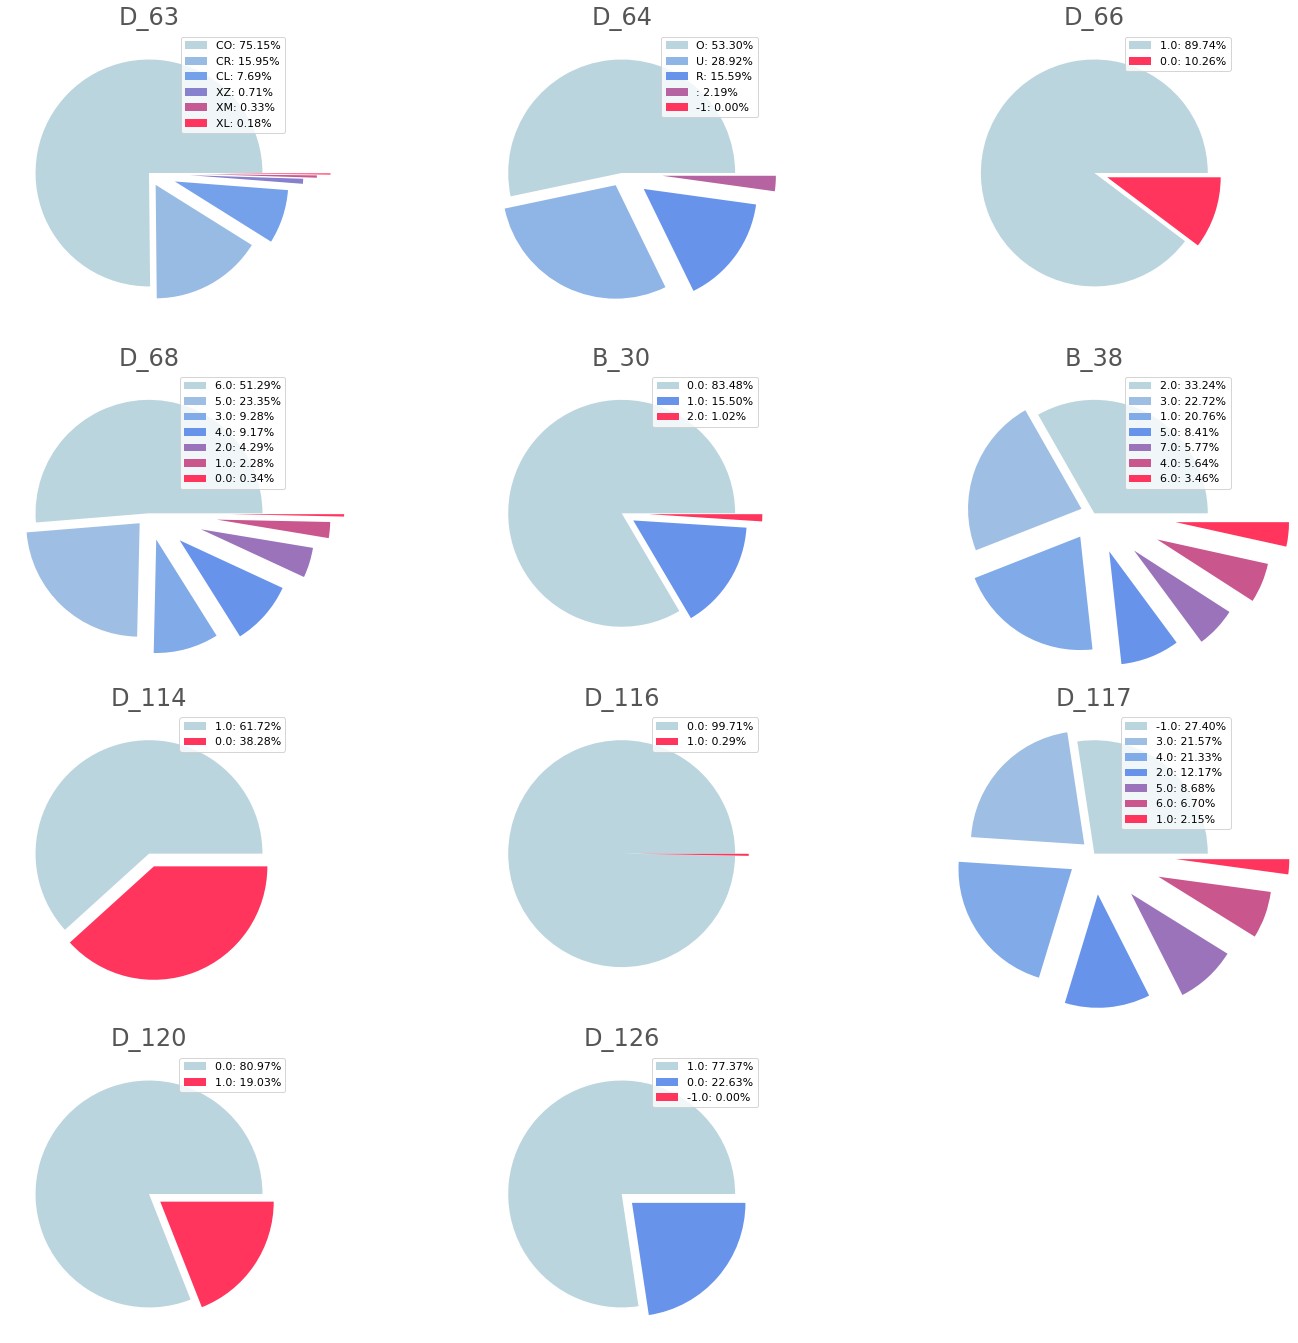

In [13]:
cat_train_df = train_df.select_dtypes(include=['category'])
fig, axs = plt.subplots(4,int(len(cat_train_df.columns)/4) + 1)
axs[-1,-1].axis('off')
for i,col in enumerate(cat_train_df.columns):
    plot_pie(train_df.select_dtypes(include=['category'])[col].value_counts(),col,24,axs[i//3,i%3])

<font size="5" style="color:#219ebc">Numerical distributions</font>

There are some density plots that show large dispersion, that might be an indication of outliers.

In [14]:
def density_plot(df, title):     
    features = train_df.select_dtypes(include=np.number).columns
    n_rows = 10
    n_cols = 5
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(24,24), sharey=False)
    
    fig.subplots_adjust(top=0.90)
    for i in range (n_rows*n_cols):
        feature = train_df.select_dtypes(include=np.number).columns[i]
        plt.subplot(n_rows,n_cols, i+1)
        ax = sb.kdeplot(data=train_df,x=feature,hue='target',palette=get_colormap(2)[1],)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_label_position('top')   
        ax.set_ylabel('')
        ax.set_yticks([])        
        ax.set_xticks([])

    plt.suptitle(title, fontsize=20)
    plt.show()

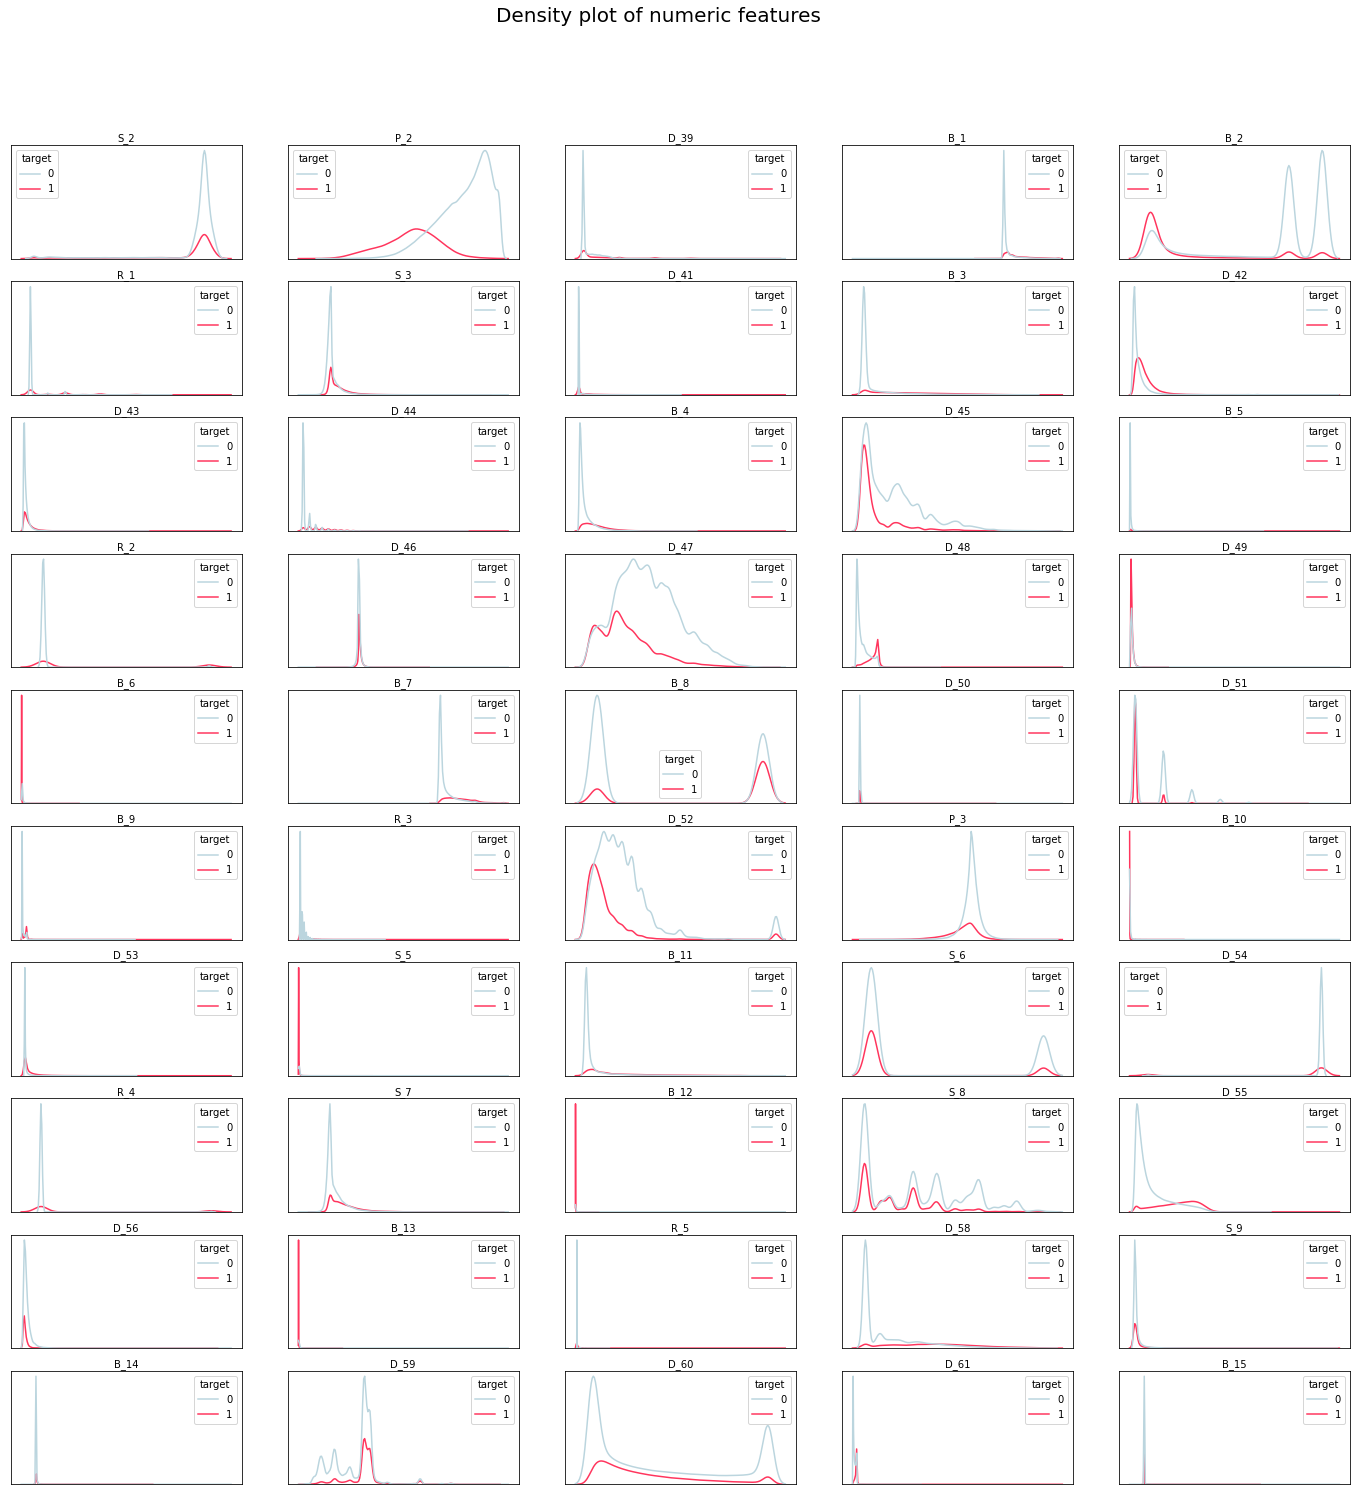

In [15]:
density_plot(train_df.sample(10000), title='Density plot of numeric features')

<font size="5" style="color:#219ebc">Missing data</font>
<div id="5">
Delinquency 87 is missing due to the proportion of null values. 

In fact, 24 of the top 30 features with missing values are in Delinquency variables.

In [16]:
def get_nan_percentajes(df:pd.DataFrame,thresh:int=0)-> pd.DataFrame:
    null_perc = df.isnull().sum().divide(len(df)).multiply(100).to_frame(name='Missing %')
    null_perc = null_perc[null_perc['Missing %']>=thresh].sort_values(by='Missing %')
    return null_perc
    
def plot_nan(df:pd.DataFrame,thresh:int=0,size:int=24)-> None:
    null_perc = get_nan_percentajes(df,thresh)
    plt.figure(figsize=(size,size))
    sb.set(font_scale=1.1)
    barplot = sb.barplot(x=null_perc['Missing %'],y=null_perc.index,orient='h',palette=get_colormap(len(null_perc))[1])
    barplot.set_title('Percentages of missing columns values',{'fontsize':size})
    #sb.set(font_scale = 2)
    barplot.set_yticks(barplot.get_yticks().tolist() ,size = size//2 + 2)
    barplot.set_xticks(barplot.get_xticks().tolist(), size = size//2 + 2)
    labels = barplot.bar_label(barplot.containers[0],fmt='%.3f')

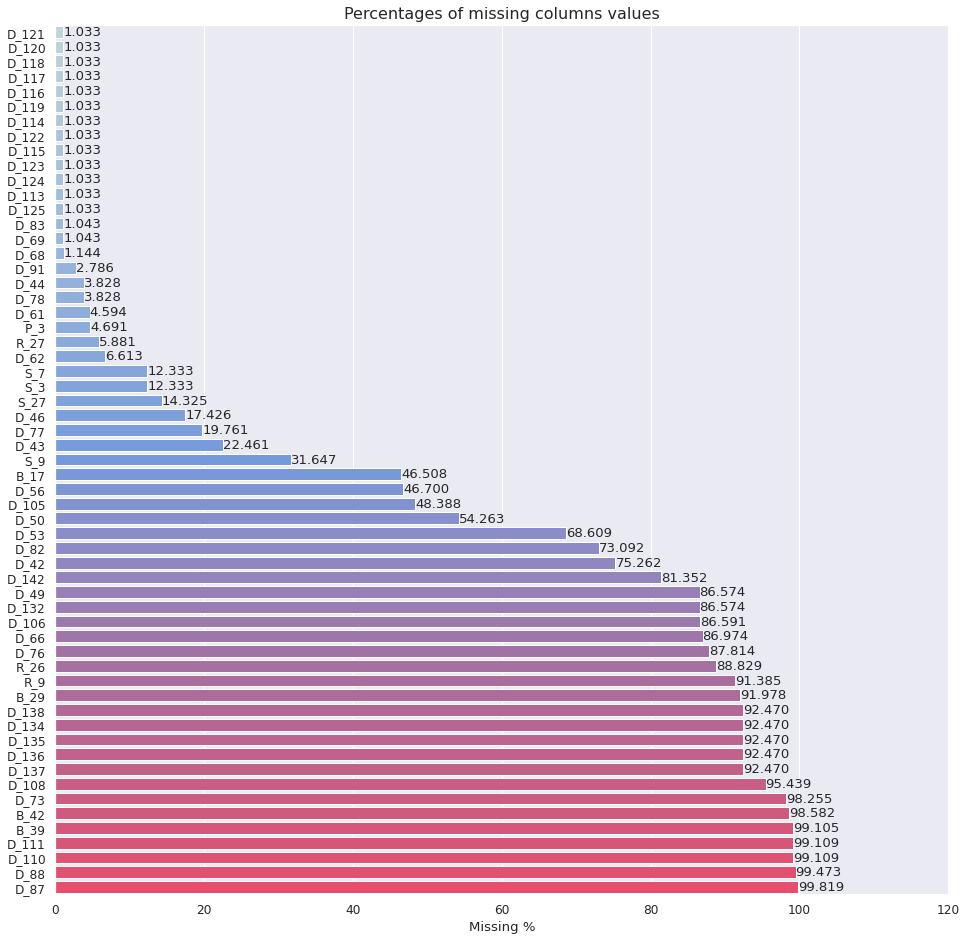

In [17]:
plot_nan(train_df,1,16)

<font size="5" style="color:#219ebc">Target distribution and correlations</font>
<div id="6">
    
- Target distribution is not balanced
    
- There are several strong correlations with the target variable. 

- Payment 2 is the most negatively correlated with the probability of defaulting with a correlation of -0.67, while Delinquency 48 is the most positively correlated overall at 0.6

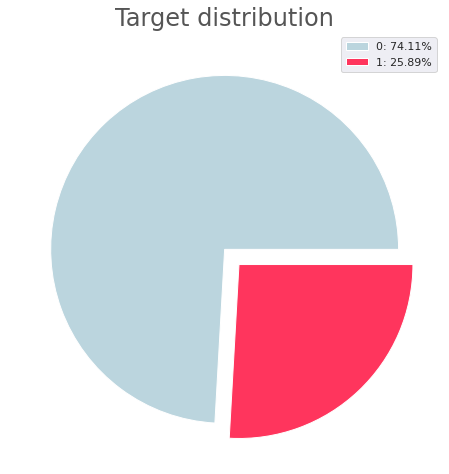

In [18]:
plot_pie(train_df['target'].value_counts(),'Target distribution',8)

In [19]:
def plot_corr(df:pd.DataFrame,corr_feature:str,size:int=34)-> None:
    feature_corr = df.corr()[corr_feature].sort_values().drop(index=corr_feature)
    plt.figure(figsize=(size,size))
    sb.set(font_scale=1.1)
    barplot = sb.barplot(x=feature_corr.values,y=feature_corr.index,orient='h',palette=get_colormap(len(feature_corr))[1])
    barplot.set_title(f'{corr_feature} features correlations',{'fontsize':size})
    #sb.set(font_scale = 2)
    barplot.set_yticks(barplot.get_yticks().tolist() ,size = size//2 + 2)
    barplot.set_xticks(barplot.get_xticks().tolist(), size = size//2 + 2)
    labels = barplot.bar_label(barplot.containers[0],fmt='%.3f')

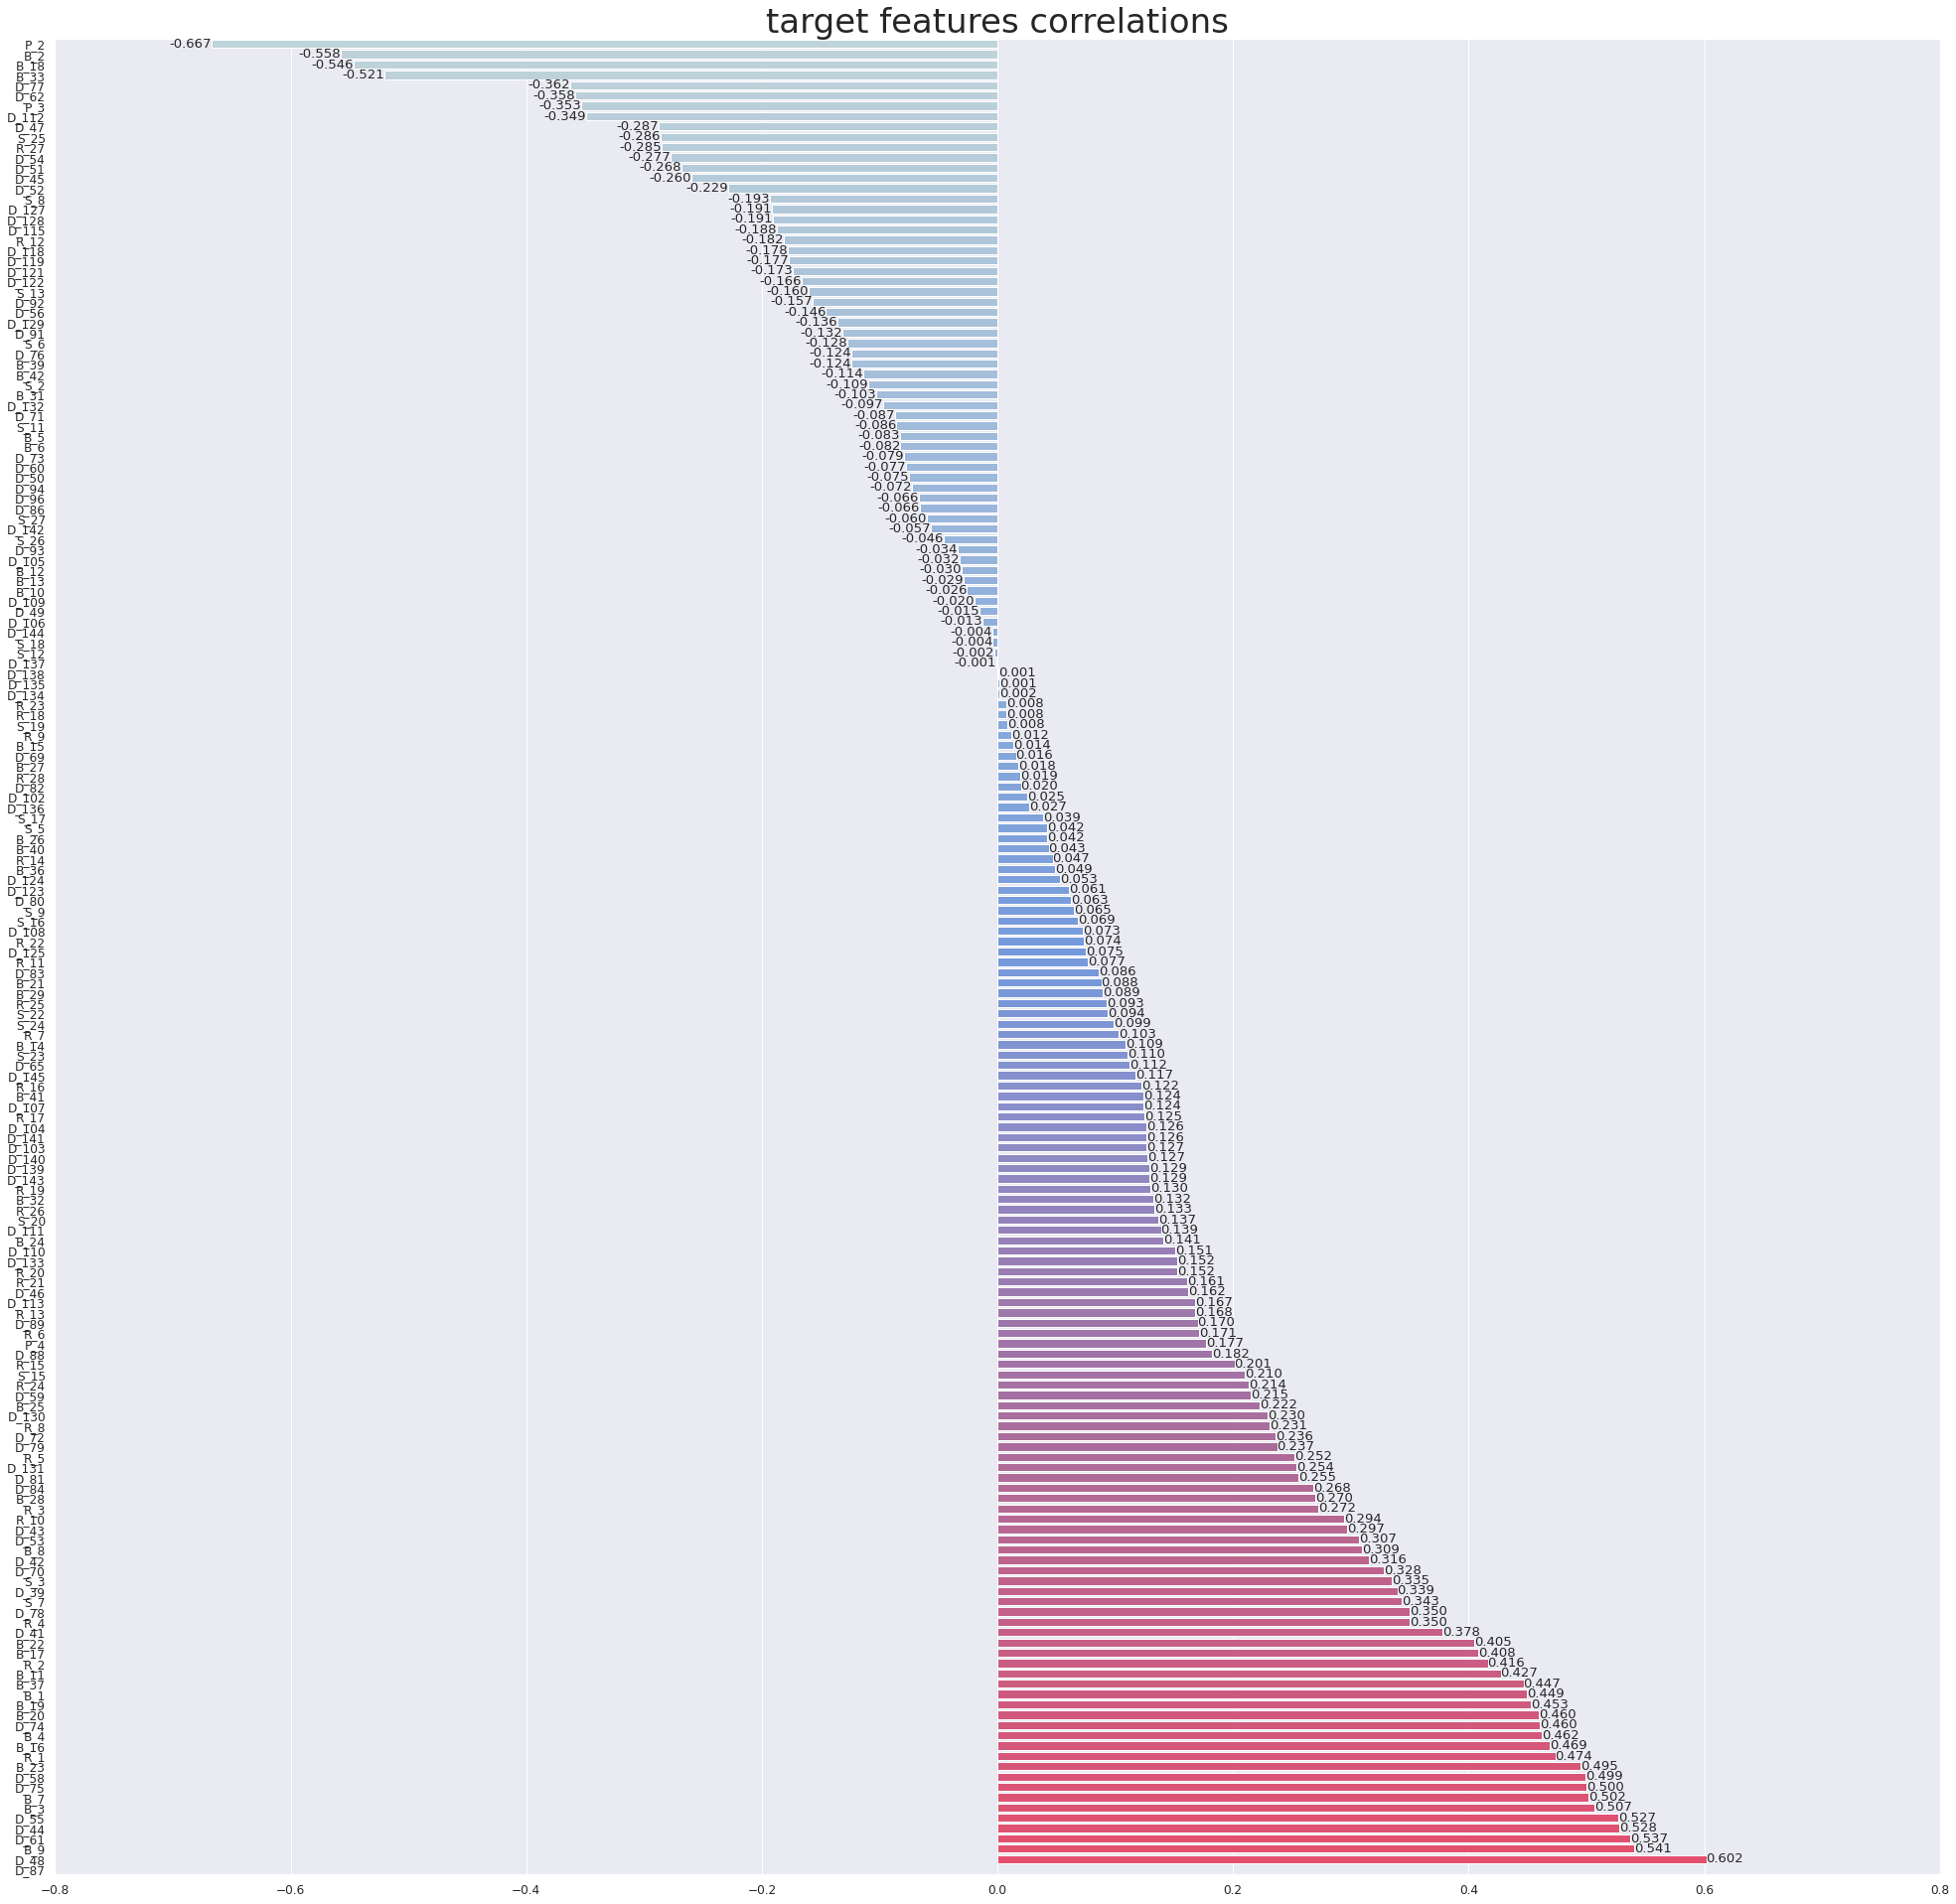

In [20]:
plot_corr(train_df,'target')